# ASL Alphabet Classifier Test - EfficientNet b4




(See "mixup: Beyond Empirical Risk Minimization" - Hongyi Zhang, Moustapha Cisse, Yann N. Dauphin, David Lopez-Pazj, 2018;  https://arxiv.org/abs/1710.09412) 

We used many state of the art techniques as well as attempting over 50 training runs using 9 different architectures.  In the end, we decided on a hacked EfficientNet model.  Some of the modifications are listed here: 

* Gradient Checkpointing --> Low-Memory Neural Network Training: A Technical Report 2019 (https://arxiv.org/abs/1904.10631)
* MaxBlurPool Layer --> Making Convolutional Networks Shift-Invariant Again 2019 (https://arxiv.org/abs/1904.11486)
* Mish Activation Function --> Mish: A Self Regularized Non-Monotonic Activation Function 2019 (https://arxiv.org/abs/1908.08681)
* Swish Activation Function --> Searching for Activation Functions 2017 (https://arxiv.org/abs/1710.05941v2)
* Rectified Adam Optimizer --> On the Variance of Adaptive Learning Rate and Beyond 2019 (https://arxiv.org/abs/1908.03265)
* Look Ahead Optimizer --> Lookahead Optimizer: k steps forward, 1 step back 2019 (https://arxiv.org/abs/1907.08610)
* Label Smoothing --> Regularizing Neural Networks by Penalizing Confident Output Distributions 2017 (https://arxiv.org/abs/1701.06548)
* CutMix --> CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features 2019 (https://arxiv.org/abs/1905.04899)
<br>

#### Datasources: 
External:
<a href="https://www.kaggle.com/grassknoted/asl-alphabet">https://www.kaggle.com/grassknoted/asl-alphabet</a>
<a href="https://www.kaggle.com/danrasband/asl-alphabet-test">https://www.kaggle.com/danrasband/asl-alphabet-test</a>

Additional data was also created in-house.

<br>



<br>
<br>
<HR/>
<br>
<br>

In [1]:
import warnings
warnings.filterwarnings('ignore')  # or 'once'  

In [2]:
import sys
sys.path.append('utils')

import pyforest

from datetime import datetime
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import fastai
import gc
from nn_utils_eff import *
from augmentation import *



USES_TIMM = True
USES_GCHKPT = True
ARCH = 'resnet50'   # xresnet50 # resnet101

CHOSEN_SAMPLE_SIZE = 3000  #1100 # 2500  # use this to control per-category sample sizes # 1000
TEST_SET_SIZE = 500  # number of images per category to put in the test set

remove_from_sample = {
#         'A': 0.5,
    'B': 0.4,
#     'C': 0.2,
# #     'D': 0.3,
#     'E': 0.2,
    'F': 0.4,
    'G': 0.3, # 0.8,
    'H': 0.4,
    'K': 0.4,
# #     'L': 0.7,
    'M': 0.6,
# #     'N': 0.9,
# #     'O': 0.2,
    'P':0.4,
    'Q': 0.6,
# #     'R': 0.4,
#     'U': 0.2
# #     'Y': 0.8 

}  # fractions of original samples to keep

add_to_sample = {  # Use this minimally until we add NEW samples rather than oversampling.
#     'A': 0.2,
#     'B': 0.2,
#     'G': 0.1,
#     'I': 0.3,
#     'K': 0.2,
#    'M': 0.2,
    'N': 0.9,
    'O': 0.2,
#     'R': 0.3,
#     'S': 0.4,
#     'T': 0.4,
    'V': 0.2,
#     'W': 0.1,
#     'Y': 0.2
}

remove_from_sample = {}
add_to_sample={}

AVG_SAMPLES = 2500  # Set this to the average number of samples per category - TOTAL = AVG*24 letters

FROZEN_EPOCHS = 1  # 1
EPOCHS = 10  # 4
BATCH_SIZE = 32  # 16
RESOLUTION = 380  # 300

PRETRAINED_FLAG = True
GRAD_ACC = 128 # set this to 64 when testing with low data.  Set it to 128, 192 or 256 when using lots of data.
VALID_PERC = 0.2

# data = 'combined3-proc2'
# data = 'combined4'
# data = 'combined5-noexternal'
data = 'combined4_with_overflow_all_d'



rn_addon = f'_data={data}'
curr_time = str(datetime.today().strftime("%Y%m%d-%H%M"))

RUN_NAME = f'{curr_time} - arch={ARCH} - samples={CHOSEN_SAMPLE_SIZE} frozen={FROZEN_EPOCHS} epochs={EPOCHS} bs={BATCH_SIZE} res={RESOLUTION} {rn_addon}'
print(f"RUN_NAME = '{RUN_NAME}'")


# set this to None if training a new model from scratch
PREV_TRAINED_MODEL_RUN_NAME = None
PREV_TRAINED_MODEL_EPOCH = None




import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
# %matplotlib widget
plt.rcParams['figure.figsize'] = [9, 5]
plt.rcParams['figure.dpi'] = 120
plt.style.use('dark_background')

%env WANDB_WATCH=false

import wandb
from fastai.callback.wandb import *

wandb.init(project="asl-sign-language-recognition", mode='disabled')
wandb.run.name = RUN_NAME



RUN_NAME = '20210326-1507 - arch=resnet50 - samples=3000 frozen=1 epochs=10 bs=32 res=380 _data=combined4_with_overflow_all_d'
env: WANDB_WATCH=false


In [3]:
# path = '../data/external/Training_Set'
path = f'../data/{data}/Training_Set'
# path2 = '../data/frank-ledlights-L'
path2 = None

<br>
<br>

## Check for an available GPU

In [4]:
import torch
print('CUDA available: '.ljust(28), torch.cuda.is_available())
print('CUDA device count: '.ljust(28), torch.cuda.device_count())

current_device = torch.cuda.current_device()
print('Current CUDA Device index: '.ljust(28), current_device)
# torch.cuda.device(current_device)
print('Current CUDA Device: '.ljust(28), torch.cuda.get_device_name(current_device))
print()
# print('CUDA available: '.ljust(24), torch.cuda.is_available())
print(f'fastai version:              {fastai.__version__}')
# print(f'fastcore version:            {fastcore.__version__}')
# print(f'fastbook version:            {fastbook.__version__}')
print(f'cuda version:                {torch.version.cuda}')
print(f'torch version:               {torch.__version__}')
# print(f'python version:              {python_version()}')

CUDA available:              True
CUDA device count:           1
Current CUDA Device index:   0
Current CUDA Device:         GeForce RTX 2070 SUPER

fastai version:              2.2.5
cuda version:                10.1
torch version:               1.7.0


<br>
<br>

### Check for Dataset Imbalance

In [5]:
from string import ascii_uppercase
import numpy as np
import operator

labels = []
labels[:0] = string.ascii_uppercase
labels.remove('J')
labels.remove('Z')


image_files = {}
image_files_qty = {}

# loop through all the characters to build dictionaries of image files and quartity of each category
for c, i in zip(ascii_uppercase, np.arange(len(ascii_uppercase))):
    
    if c == 'J' or c == 'Z': continue  # we don't use these characters
        
    image_files[c] = get_image_files(path + f'/{c}')
    
    if path2 != None:  # additional data
        image_files[c] += get_image_files(path2 + f'/{c}')

        
    l = len(image_files[c])
    image_files_qty[c] = l
    

# Get the character with the largest and smallest number of entries
maxqc = max(image_files_qty, key=image_files_qty.get)
minqc = min(image_files_qty, key=image_files_qty.get)


print()
print(f'Character with the most images:   {maxqc},   with {image_files_qty[maxqc]} images')
print(f'Character with the least images:  {minqc},   with {image_files_qty[minqc]} images')
print(f'Average number of images:         {round(np.mean(list(image_files_qty.values())))}')




Character with the most images:   F,   with 12849 images
Character with the least images:  T,   with 7976 images
Average number of images:         8885


<br>
<br>

<br>
<br>

# Data Preparation and EDA

## Display the number of image files for each category

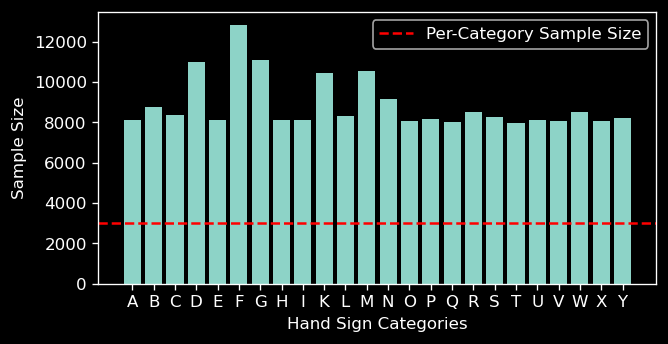

In [6]:
# plt.hist(image_files_qty.items)
plt.figure(figsize=(6,3))
plt.bar(image_files_qty.keys(), image_files_qty.values())
plt.axhline(CHOSEN_SAMPLE_SIZE, ls='--', color='r', label='Per-Category Sample Size')
plt.xlabel('Hand Sign Categories')
plt.ylabel('Sample Size')
plt.legend();

<br>
<br>

### Balance the Dataset with Oversampling or Undersampling

Sampled size is modulated by variable `CHOSEN_SAMPLE_SIZE` and will oversample or undersample (or both) depending on the amount of data available vs the chosen sample size

In [7]:
import pandas as pd

maxq = image_files_qty[maxqc] # the quantity of the largest category
minq = image_files_qty[minqc] # the quantity of the smallest category

all_image_files = {}  # holds all the image files in one dataframe
train_image_files = {}
test_image_files = {}

for char, q in iter(image_files_qty.items()):

    image_files_list = list(image_files[char]) 
    
    

#     # undersample or over sample as needed
    if CHOSEN_SAMPLE_SIZE > 0:  # neg sample size means keep the entire set
        if len(image_files_list) >= CHOSEN_SAMPLE_SIZE:
            image_files_list = np.random.choice(image_files_list, CHOSEN_SAMPLE_SIZE, replace=False)  # undersample
        else:
            delta = CHOSEN_SAMPLE_SIZE - len(image_files_list)
            image_files_list.append(np.random.choice(image_files_list, delta, replace=(delta > len(image_files_list))))  # oversample
        
    # siphon off the test set
    test_image_files[char] = np.random.choice(image_files_list, size=TEST_SET_SIZE, replace=False)
    
    train_image_files[char] = list(set(image_files_list) - set(test_image_files[char]))

       
# test_image_files = test_image_files.sample(frac=1, replace=False)  # shuffle - training set is shuffled later

<br>
<br>

### Ensure the Dataset is Balanced (if desired)

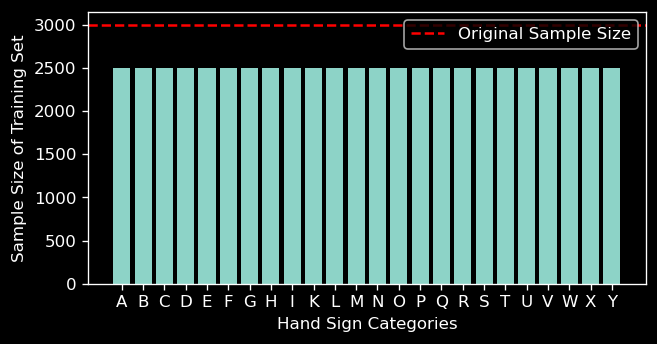

In [8]:
if CHOSEN_SAMPLE_SIZE > 0:
    plt.figure(figsize=(6,3))
    plt.bar(train_image_files.keys(), [len(l) for l in train_image_files.values()])
    # plt.ylim(0, CHOSEN_SAMPLE_SIZE)
    plt.axhline(CHOSEN_SAMPLE_SIZE, ls='--', color='r', label='Original Sample Size')
    plt.xlabel('Hand Sign Categories')
    plt.ylabel('Sample Size of Training Set')
    plt.legend();
else: print('CHOSEN_SAMPLE_SIZE was unspecified - using the entire set.')

<br>
<br>

### Check the  Test Set

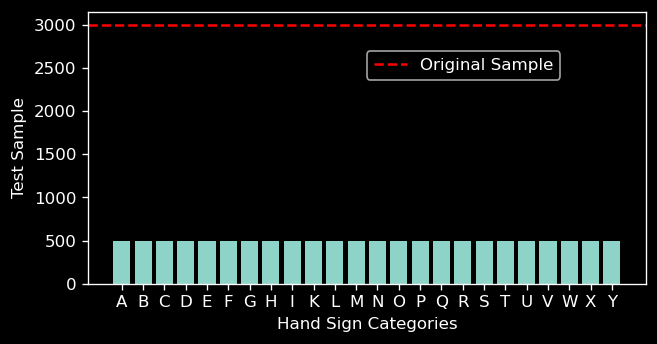

In [9]:
fig, ax = plt.subplots(figsize=(6,3))
ax.bar(test_image_files.keys(), [len(l) for l in test_image_files.values()])
ax.axhline(CHOSEN_SAMPLE_SIZE, ls='--', color='r', label='Original Sample')
plt.xlabel('Hand Sign Categories')
plt.ylabel('Test Sample')
# formatter = ticker.PercentFormatter()
# ax.yaxis.set_major_formatter(formatter)
plt.legend(loc=(0.5,0.75));

<br>
<br>

<br>
<br>

### Deliberately Adjust the Sample Size of Certain Categories to Fine Tune the Model
Because the data is so easy to overfit and because we see certain categories fitting faster/stronger than others - causing the model to always select those categories... we try to balance that effect by decreasing the number of samples. 

In [10]:
for key in remove_from_sample:
#     train_image_files[key] = train_image_files[key], (1 - remove_from_sample[key])
    len_files = len(train_image_files[key])
    train_image_files[key] = random.sample(train_image_files[key], int((1-remove_from_sample[key]) * len_files))
    
## @TODO: sample outside the training set rather than oversampling.
for key in add_to_sample:
    len_files = len(train_image_files[key])
    train_image_files[key].extend(random.sample(train_image_files[key], int(add_to_sample[key] * len_files)))
    


<br>
<br>

### Check that the Training Dataset has been Appropriately Altered

In [11]:
if remove_from_sample != {}:
    fig, ax = plt.subplots(figsize=(6,3))
    plt.bar(train_image_files.keys(), [len(l) for l in train_image_files.values()])
    plt.xlabel('Hand Sign Categories')
    plt.ylabel('Sample Size')
    plt.show()
    
else:
    print('\nNo dataset alterations were selected.')


No dataset alterations were selected.


<br>
<br>

## Bring the total samples up/down to the chosen mean

In [12]:
# mean = np.mean(np.concatenate(*train_image_files).flat)
mean = np.mean([len(cfiles) for cfiles in train_image_files.values()])
ratio = AVG_SAMPLES / mean

for key in train_image_files:
    train_image_files[key] = np.random.choice(train_image_files[key], size= int(ratio * len(train_image_files[key])))

<br>
<br>

### Check that the Training Dataset has been Appropriately Altered

Average categorical sample size was:            2500
New catorical sample size (after alteration):   2500



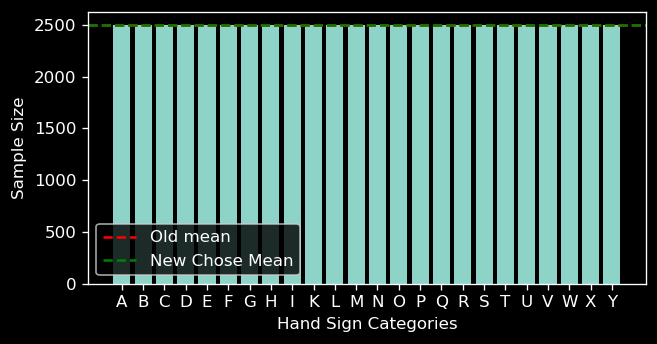

In [13]:
print(f'Average categorical sample size was:            {int(mean)}')
print(f'New catorical sample size (after alteration):   {AVG_SAMPLES}\n')

fig, ax = plt.subplots(figsize=(6,3))
plt.bar(train_image_files.keys(), [len(l) for l in train_image_files.values()])
plt.axhline(mean, ls='--', color='red', label='Old mean')
plt.axhline(AVG_SAMPLES, ls='--', color='green', label='New Chose Mean')    
plt.xlabel('Hand Sign Categories')
plt.ylabel('Sample Size')
plt.legend()
plt.show()
    


<br>
<hr/>
<br>
<br>
<br>

## Model Creation and Training

<br>

<br>

### Create the DataBlock, while Resizing and Augmenting

In [14]:
item_tfms = [ToTensor(), AlbumentationsTransform(get_train_aug(RESOLUTION), get_valid_aug(RESOLUTION))]
batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

In [15]:
import random

# Needed to pass into the DataBlock    
def get_fnames(path): 
    retlist = []

    for arr in train_image_files.values():
        for f in arr:
            retlist.append(f)
        
#     return random.shuffle(retlist) # random.sample(retlist, len(retlist))  # shuffle
    return random.sample(retlist, len(retlist))  # shuffle

    
    
    
signs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_fnames, 
    splitter=RandomSplitter(valid_pct=0.25, seed=42),
    get_y=parent_label,
    item_tfms=item_tfms, batch_tfms=batch_tfms)



<br>
<br>

<br>

### Load the Data by Path

In [16]:
dls = signs.dataloaders(path, bs=BATCH_SIZE)
# wandb.log({'dataset':'../data/external/Training Set'})

<br>

### Verify the Training and Validation Batches

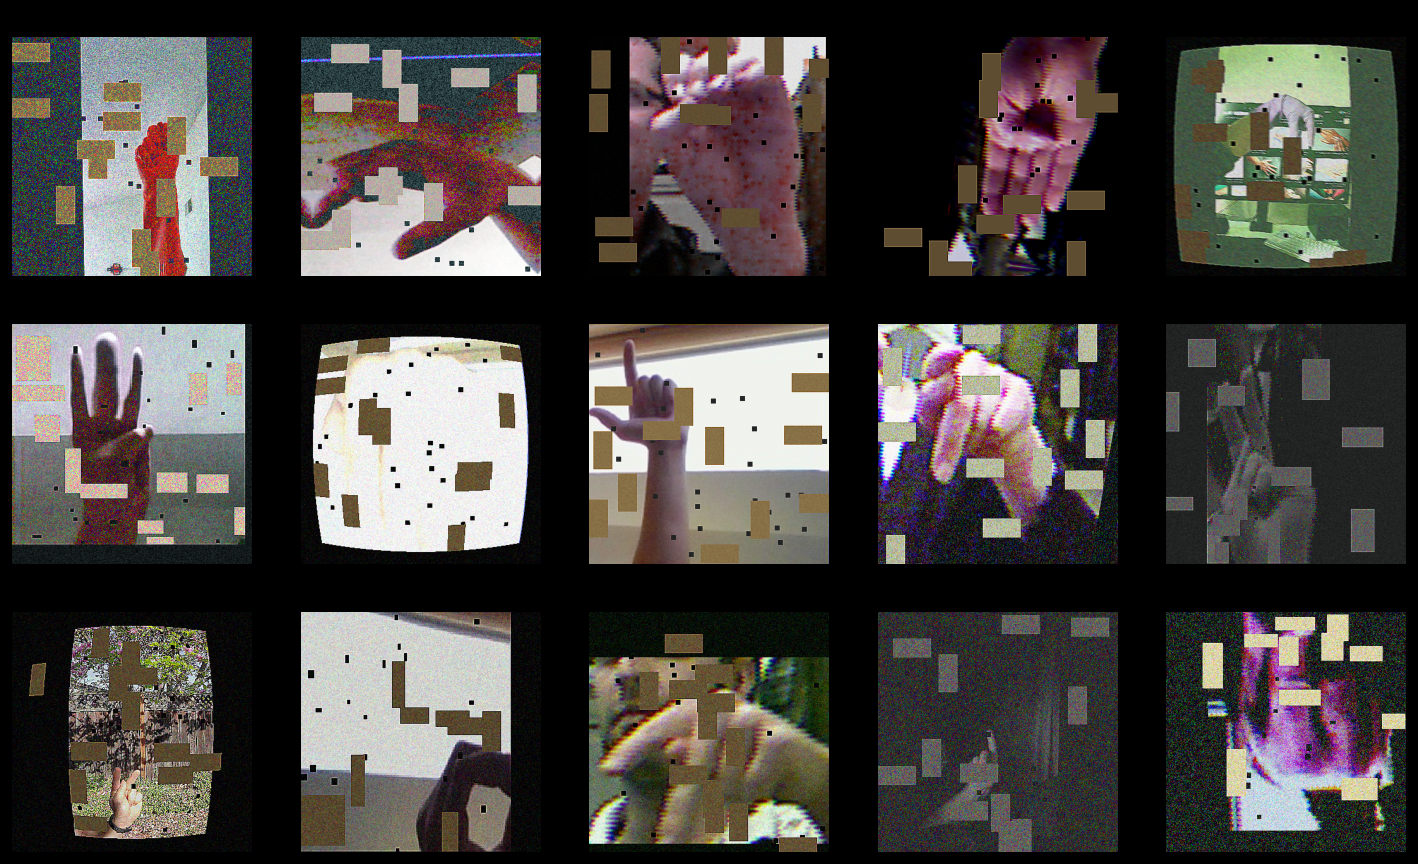

In [17]:
dls.train.show_batch(max_n=15)

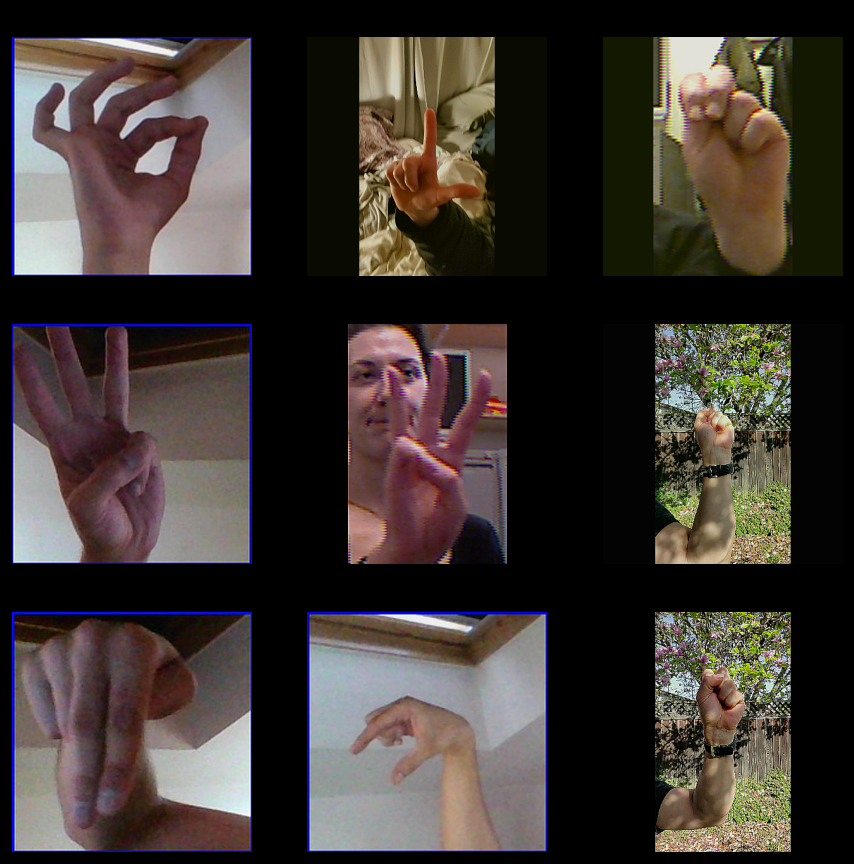

In [18]:
dls.valid.show_batch(max_n=9)

<br>
<br>

<br>
<br>
<br>

## Create Callbacks

In [19]:
cutmix_cb = None
mixup_cb = None

def create_callbacks(patience=3):
    global cutmix_cb, mixup_cb  # use the global version

    # Eary stopping callback
    # We set the patience high because valid_loss reporting will not track perfectly at every
    # epoch because we are using Gradient Accumulation
    early_stop_cb = EarlyStoppingCallback(monitor='valid_loss', patience=patience, reset_on_fit=True)

    # Save the current model's weights every epoch
    save_cb = SaveModelCallback(fname=RUN_NAME, with_opt=True, every_epoch=True)

    # Reduce the Learning Rate if valid_loss flatlines
    reduceLR_cb = ReduceLROnPlateau(monitor='valid_loss', min_delta=0.01, min_lr=1e-8, patience=3, factor=10, reset_on_fit=True)

    # Mixup callback for regularization
    # mixup_cb = MixUp(alpha=0.3)
    mixup_cb = None

    # Cutmix callback for regularization
    cutmix_cb = CutMix()
#     cutmix_cb = None

    # Gradient Accumulation
    # gradacc_cb =  GradientAccumulation(n_acc=16)
    gradacc_cb =  GradientAccumulation(n_acc=128)
  
    # log our runs
    csv_log_cb = CSVLogger(fname=f'CSV-History/{RUN_NAME}.csv', append=True)


    # List of callbacks to be used later
    cbs = [save_cb, ShowGraphCallback(), GradientClip(), early_stop_cb, gradacc_cb]  #, reduceLR_cb, early_stop_cb, csv_log_cb] #, reduceLR_cb]

    if mixup_cb != None:
        cbs.insert(0, mixup_cb)

    if cutmix_cb != None:
        cbs.insert(0, cutmix_cb)

    print('\nAll Callbacks: ', cbs)
    return cbs

# empty
cbs = create_callbacks()


All Callbacks:  [CutMix, SaveModelCallback, ShowGraphCallback, GradientClip, EarlyStoppingCallback, GradientAccumulation]


<br>
<br>

### Visualize the effect of CutMix


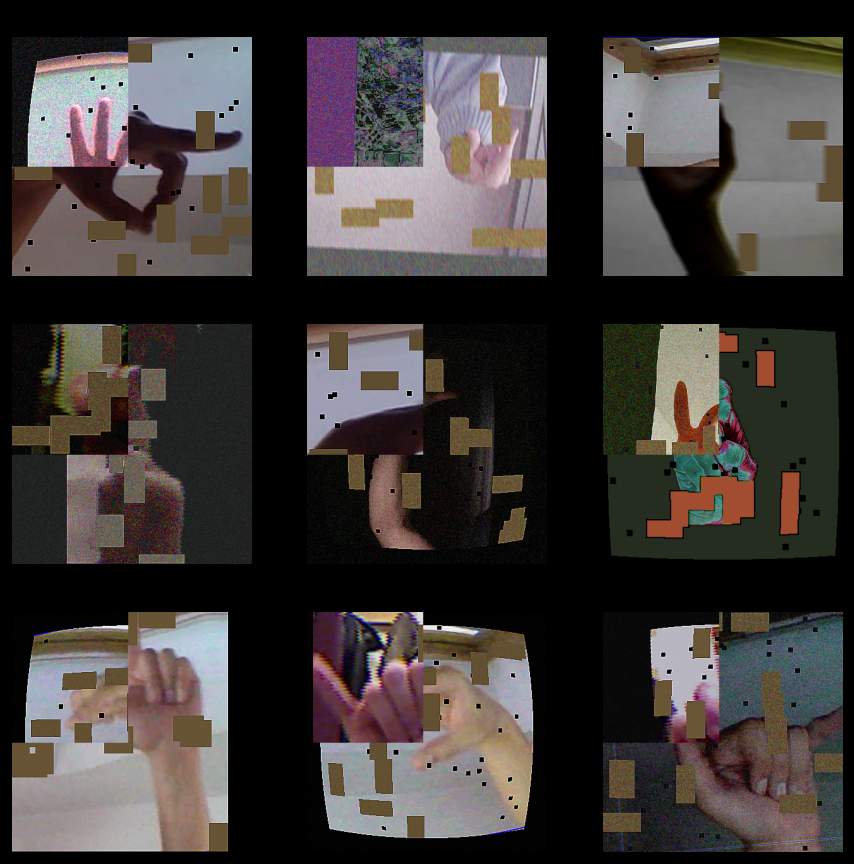

In [20]:
if cutmix_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(cutmix_cb.x,cutmix_cb.y), ctxs=axs.flatten())
    
else: print('\n CutMix was not selected.')

<br>

### Visualize the Effect of MixUp

MixUp creates a linear interpolation between the target data and another datapoint.  In images, it shows up as ghostly figures.  The technique has been shown to be a good to decrease the liklihood of overfitting.

In [21]:
if mixup_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(mixup_cb.x,mixup_cb.y), ctxs=axs.flatten())

else: print('\n MixUp was not selected.')


 MixUp was not selected.


<br>
<br>

<br>
<br>

# Model Instantiation

## Define the model and fit

#### We define a custom head since the default one was prone to overfitting.

Here, we decrease the channels in the hidden layer as well as increase dropout.  We found no change in expressivity.

In [22]:
custom_head = nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    Flatten(full=False),
    nn.BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=2048, out_features=256, bias=False),
    MishAuto(inplace=True),
    nn.BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=256, out_features=24, bias=True)
)

In [23]:
import timm


def create_learner(cat_weights=None):
    # Create the learner
    learn = cnn_learner(dls, 
                         resnet50, custom_head=custom_head,
                         opt_func=ranger,
                         loss_func=LabelSmoothingCrossEntropyFlat(weight=cat_weights),
#                          loss_func=CrossEntropyLossFlat,
                          cbs=create_callbacks(), 
                         pretrained=PRETRAINED_FLAG,
                         metrics = [error_rate, accuracy, RocAuc()]
                        )


    # Learner Surgery - replacing modules
    learn.model[0] = convert_seq_chkpt(learn.model[0], nn.Sequential)  # hack in gradient checkpoints for memory savings
#     learn.model[0] = nn.Sequential(CheckpointModule(learn.model[0], 1))  # hack in the final checkpointmodule for the base sequence
#     learn.model[0] = CheckpointModule(learn.model[0], 1)  # hack in the final checkpointmodule for the base sequence

    learn = convert_MP_to_blurMP(learn, nn.MaxPool2d)  # replace max pool with with BlurMaxPool (if it exists)
    learn.model[1] = convert_act_cls(learn.model[1], nn.ReLU, MishAuto())  # very expensive so we only use it on the head
    learn.model[0] = convert_act_cls(learn.model[0], nn.ReLU, SwishAuto())  # replace with a lower memory version
    
#     learn = learn.to_fp16()  # convert to mixed precision for memory savings

    learn = learn.to_non_native_fp16()

    return learn


In [24]:
learn = create_learner()


All Callbacks:  [CutMix, SaveModelCallback, ShowGraphCallback, GradientClip, EarlyStoppingCallback, GradientAccumulation]


<br>
<br>

### Look at the Loss Function, Optimization Function and Model Architecture

In [25]:
print('\nLoss Function: ', learn.loss_func)
print('\nOptimization Function: ', learn.opt_func)
print('\n\n', learn.model[1])  # show just the head


Loss Function:  FlattenedLoss of LabelSmoothingCrossEntropy()

Optimization Function:  <function ranger at 0x7f6b56c22040>


 Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(full=False)
  (2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=2048, out_features=256, bias=False)
  (5): MishAuto()
  (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=256, out_features=24, bias=True)
)


<br>
<br>

# ------------------- RUN TO HERE ---------------------------

<br>


<br>
<br>
<br>

## Find a Good Learning Rate to Start With

Note: we can pretty much ignore this particular lr finder graph because it won't show ture for small batch sizes and gradient accumulation. 

We tuned the learning rate earlier by disabling gradient accumulation, setting the resolution low and increasing the batch size.  After finding an appropriate learning rate, we reset the parameters to high(er) resolution, low batch size and re-enabling the gradient accumulation callback.

In [26]:
LR_DIV = 14e0  # Shift the lr_min left by this amount.  Adjust as necessary
lr_min = 0.002  # just a default

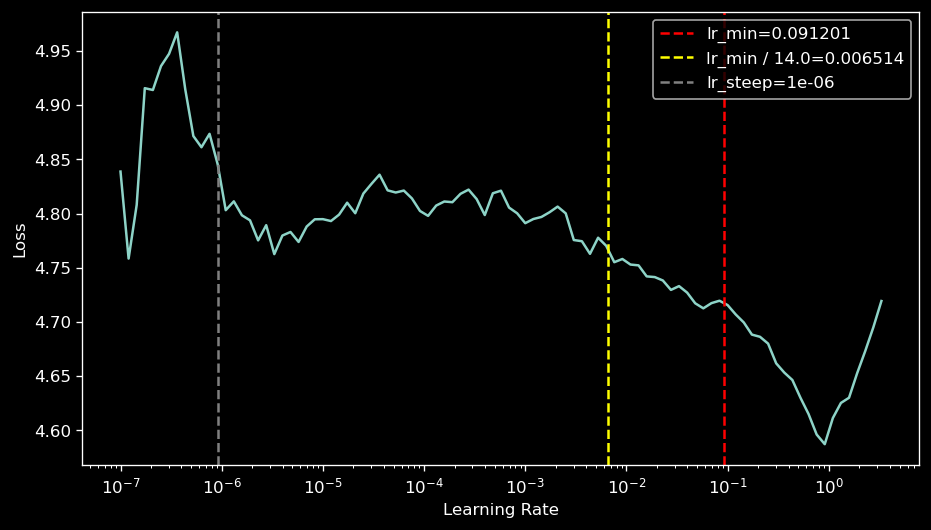

Minimum/10: 9.12e-02, steepest point: 9.12e-07, (Mim/10)/14.0: 0.006514363203729902


In [27]:
if PRETRAINED_FLAG == True:
    learn.freeze()
    lr_min,lr_steep = learn.lr_find()
    plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
    plt.axvline(lr_min/LR_DIV, ls='--', color='yellow', label=f'lr_min / {LR_DIV}={round(lr_min/LR_DIV,6)}')
    plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
    plt.legend()
    plt.show()

    print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}, (Mim/10)/{LR_DIV}: {lr_min/LR_DIV}")

<br>
<br>

# Pick a Good Initial Learning Rate

In [28]:
# LR_CHOICE = lr_min/LR_DIV
# LR_CHOICE = lr_steep
LR_CHOICE = 7e-3 # /2  # worked great
#LR_CHOICE = 7e-5
# LR_CHOICE = 1e-2

<br>
<br>

<br>
<br>

# Training the Model

<br>

## Fit the Head



FROZEN_EPOCHS:  1
Learning Rate:  0.007




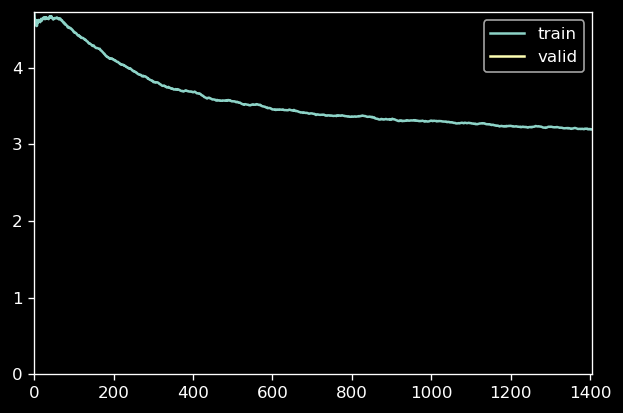

In [29]:


print(f'FROZEN_EPOCHS:  {FROZEN_EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE}\n\n')


if PRETRAINED_FLAG == True:
    learn.fit_flat_cos(FROZEN_EPOCHS, LR_CHOICE, pct_start=0.99, wd=0.01, reset_opt=True)


In [30]:
# Persist a Copy

# Need to do this first as it won't pickle with the CSV logger
# learn.remove_cbs(CSVLogger)

learn.export(f'models/STAGE1_{RUN_NAME}.pkl')
print(f'Saved to: models/STAGE1_{RUN_NAME}.pkl')

# put the logger back in
# learn.add_cbs(CSVLogger(fname=f'{RUN_NAME}.csv', append=True))

Saved to: models/STAGE1_20210326-1507 - arch=resnet50 - samples=3000 frozen=1 epochs=10 bs=32 res=380 _data=combined4_with_overflow_all_d.pkl


<br>
<br>

## Fit the Whole Model

As before, we can safely ignore the results of the LR finder graph.  We previously tuned the LR especially so that we can fit the model onto the GPU with a small batch size (+ gradient accumulation)

In [31]:
learn.unfreeze()

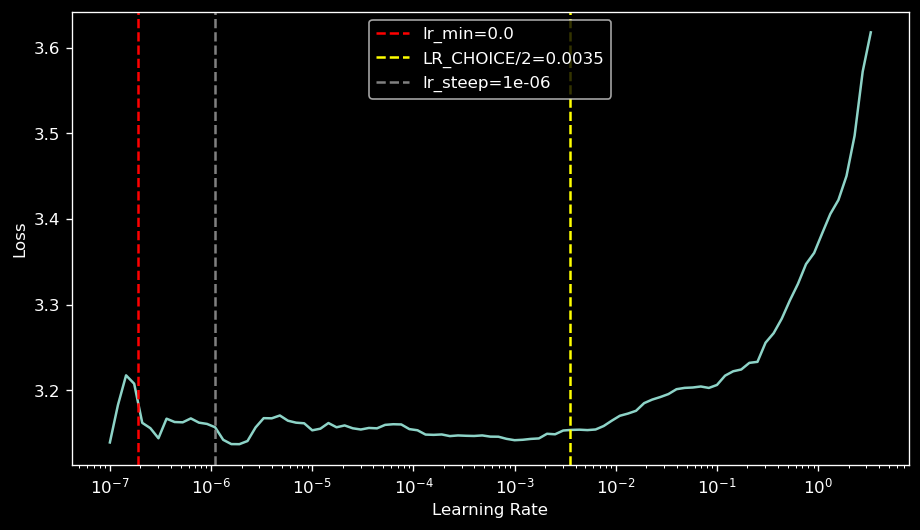

In [32]:
lr_min,lr_steep = learn.lr_find()
plt.axvline(lr_min, ls='--', color='red', label=f'lr_min={round(lr_min,6)}')
plt.axvline(LR_CHOICE/2, ls='--', color='yellow', label=f'LR_CHOICE/2={round(LR_CHOICE/2,6)}')
plt.axvline(lr_steep, ls='--', color='grey', label=f'lr_steep={round(lr_steep,6)}')
plt.legend()
plt.show()

In [33]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}, LR_CHOICE/2: {LR_CHOICE / 2}")

Minimum/10: 1.91e-07, steepest point: 1.10e-06, LR_CHOICE/2: 0.0035


<br>
<br>

### Pick a new Learning Rate

Note: We have previously shown we can get to 99.9% accuracy in 4 epochs, but here we deliberately choose a much lower learning rate and change the weight decay (L2 analog when using decoupled WD) for the following reasons:

1. Label Smoothing (as a regularization technique) is only applied during loss computation and since it decreases the ratio between expected True values and False values, it requires many mini-batches to be effective ... to differentiate when calculating "predictive confidence"
2. Due to the poor 3rd party data and the limited capacity imposed on our own collection methodology, the data is quite homogenous.  We try to mitigate this issue with a great deal of augmentation and regularization.  Decreasing the learning rate increases the training time and exposes the model to more types of augmentation.

In [34]:
# LR_CHOICE_UNFROZ = lr_min/LR_DIV
# LR_CHOICE_UNFROZ = LR_CHOICE / 2  

LR_CHOICE_UNFROZ = 7e-4 # /10 #/ 20 
# 7e-4 worked great

<br>
<br>

## Train

In [35]:
print(f'EPOCHS:         {EPOCHS}')
print(f'Learning Rate:  {LR_CHOICE_UNFROZ}\n\n')

EPOCHS:         10
Learning Rate:  0.0007




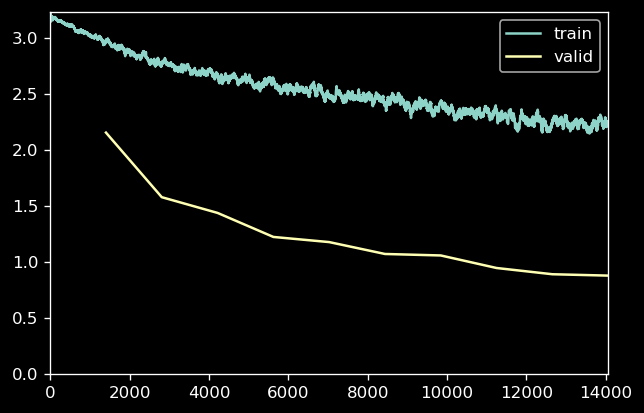

Max GPU Memory Allocated: 4.47017728 GB


In [36]:
# learn.fit_flat_cos(EPOCHS, slice(LR_CHOICE_UNFROZ), pct_start=0.68)

# learn.fit_one_cycle(EPOCHS, slice(LR_CHOICE_UNFROZ),  wd=1e-2)

learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.6, wd=1e-2, reset_opt=False)
# fit_hump(learn, EPOCHS, lr_max=LR_CHOICE_UNFROZ, reset_opt=True)

print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
torch.cuda.reset_max_memory_allocated()

<br>
<br>

## Persist the Model

In [37]:

# save the raw version
learn.export(f'../models/{RUN_NAME}-WITH_CBS.pkl')

# save a version for inferrences only
c = remove_cbs(learn)
learn.export(f'../models/{RUN_NAME}.pkl')
with open(f'models/DLS/{RUN_NAME}-DLS.pkl', 'wb') as f:
    pickle.dump(learn.dls, f)  # save the data loaders as they hold the split data
    
# path = Path('../models')
# path.ls(file_exts='.pkl')

RuntimeError: [enforce fail at inline_container.cc:274] . unexpected pos 54160000 vs 54159888

<br>
<br>
<br>
<br>
<br>
<br>

## Tune the model - use this to load a model and retune

In [ ]:
learn.fit_flat_cos(EPOCHS, LR_CHOICE_UNFROZ, pct_start=0.8, wd=1e-2, reset_opt=False)
# fit_hump(learn, EPOCHS, lr_max=LR_CHOICE_UNFROZ, reset_opt=True)

print(f'Max GPU Memory Allocated: {torch.cuda.max_memory_allocated()/1000000000} GB')
torch.cuda.reset_max_memory_allocated()

<br>
<br>

## Persist the Model

In [ ]:

# save the raw version
learn.export(f'../models/{RUN_NAME}-WITH_CBS.pkl')

# save a version for inferrences only
c = remove_cbs(learn)
learn.export(f'../models/{RUN_NAME}.pkl')
with open(f'models/DLS/{RUN_NAME}-DLS.pkl', 'wb') as f:
    pickle.dump(learn.dls, f)  # save the data loaders as they hold the split data
    
# path = Path('../models')
# path.ls(file_exts='.pkl')

<br>
<br>

### Show some Results

In [ ]:
# learn.show_results()

<br>
<hr>
<br>
<br>
<br>

# Validation Set (not test set) Analysis

Note that FastAI's `ClassificationInterpretation.from_learner()` method does not work on very large datasets due to a memory issue.  In any case, its utility is limited in many ways since it just interprets the validation set that was used for training - which we know will report 99+% accuracy.  On final runs, we skip this entire section in favor of testing agaist a working test set.

<br>

### Visualize with a confusion Matrix

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
interp.most_confused()[:10]

<br>
<br>

## Classification Report

In [ ]:
interp.print_classification_report()

<br>

### Show the top 15 most error prone images

In [ ]:
interp.plot_top_losses(15, nrows=3)

<br>
<br>

<br>

# ~~Clean the images that were hard to interpret and obviously bad~~

(I had to remove this section as it was assigning too much RAM and crashing the kernel)

### ~~Show a Widget that allows us to mark poor exemplars for deletion~~

In [ ]:
# import gc
# cleaner = None
# gc.collect()

# cleaner = ImageClassifierCleaner(learn)
# cleaner

### ~~Show the Indexes of the images we want to delete~~

In [ ]:
# cleaner.delete()

### ~~Delete the files~~

In [ ]:
# import os

# for idx in cleaner.delete():
#     print(f'removing: {str(cleaner.fns[idx])}')
#     os.remove(str(cleaner.fns[idx]))

<br>
<br>
<hr>
<br>
<br>




<br>
<br>

# Test Set Analysis

Note that this test set was pre-sampled from the same dataset that comprises the training set.  While the model has never seen these images, the homogenous nature of the data means that these will be practically the same as it was trained on.  We use it here for analysis but it should not be used as a model metric.

<br>

### Housecleaning

In [ ]:

    
cleanup()

<br>
<br>

### instantiate a learner object

In [ ]:
# test_learn = learn
# num = 3
# RUN_NAME='20210122-0037 - arch=xresnet50_deep - samples=3000 frozen=1 epochs=40 bs=16 res=360 _data=external'
# RUN_NAME = '20210122-2356 - arch=xresnet50_deep - samples=3000 frozen=1 epochs=40 bs=16 res=360 _data=external'

# test_learn = load_learner(f'../models/{RUN_NAME}.pkl', cpu=False)
# load_model(f'models/{RUN_NAME}_{num}.pth', test_learn, opt=Adam, with_opt=False)



test_learn = learn

In [ ]:
def get_test_fnames(path):
    l = [ _l for _ls in list(test_image_files.values()) for _l in _ls]  # flat list
    
    return random.sample(l, len(l))  # shuffled at dataloader

In [ ]:
path

In [ ]:
test_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_test_fnames,
    get_y=parent_label, 
    item_tfms=item_tfms, batch_tfms=batch_tfms)


dls = test_db.dataloaders(path, bs=BATCH_SIZE, shuffle_train=True)

test_dl = dls.test_dl(get_test_fnames('None'), with_labels=True)

<br>
<br>

###  Get the Inferrences on the Test Set

In [ ]:
inputs, preds, targs, decoded, losses = test_learn.get_preds(dl=test_dl, with_input=True, with_decoded=True, with_loss=True)

In [ ]:
interp = ClassificationInterpretation(dl=test_dl, inputs=inputs, preds=preds, targs=targs, decoded=decoded, losses=losses )

<br>

### Visualize with a confusion Matrix

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
interp.most_confused()[:10]

<br>
<br>

## Classification Report

In [ ]:
interp.print_classification_report()

In [ ]:
interp.plot_top_losses(k=15)

<br>
<br>
<br>

## Close WandB

<br>

In [ ]:
wandb.join()

In [ ]:
wandb.finish()

<br>
<br>
<br>
<hr>
<br>

# Log

* started to plot the learning rates and started to use that information while fitting.
* Downgraded to resnet34 @ 300px in order to increase the resolution fed to the model from 128px to 300px - this made a major difference.
* Decreased the number of training epochs to 6 after experimenting to find the sweet spot. - also positive change
* Changed to exclusively use fine-tune() with it's built in freeze_epochs parameter
* Changed the Batch Size in order to bring the arch back to resnet101 @300px
* Cleaned up the markdown, removed cells and reordered the rest.
* Added an Early Stop.  Starting with 0.01 delta.  
* Now moving to 0.1 delta
* Integrated wandb to keep track of experiments.
* added section to balance the dataset through oversampling.

** Attempting a batch size of 12 and 384px with resnet101.  long training times.
** Also increased the epochs to 4 on the final layer and 7 on the rest.
    

<br>
<br>

## Archive this version of the notehook

In [ ]:
import os
import shutil

# Allow Jupyter the opportunity to autosave
#!sleep 20
# time = '20210122-2356'
# curr_time = '20210320-1407'
# copy the notebook file - the prefix links it to the saved model
shutil.copyfile('Sign4 - EfficientNetLite.ipynb', f'Archive/{curr_time} - Sign4 - EfficientNetLite-92perc.ipynb')

<br>
<br>

<br>
<br>

# Test Set Analysis 2 - external holdout dataset


All of these images are out of sample and many of them exhibit stylistic variations that the model hasn't been trained on.  

An example of this is the 'T' handsign which is a variation that doesn't look like a canonical ASL 'T'.  For this run, we remove some of the 'T's.  With them in the test set, we still achieve 91%.

Notice the difficulty it has with distinguishing 'N' and 'M'.  These two are very similar signs.  And also very similar to the more 'T' as represented in most ASL dictionaries (but not exemplified in this test set).

<br>

In [ ]:
cleanup()

In [ ]:
import sys
sys.path.append('utils')

import pyforest

from datetime import datetime
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import fastai
import gc
from nn_utils_eff import *
from augmentation import *

RESOLUTION=380
BATCH_SIZE=48

In [ ]:
test_learn = learn

In [ ]:
test_learn.remove_cbs([ModelToHalf, NonNativeMixedPrecision])
test_learn.remove_cbs(cbs)

In [ ]:
def get_test_fnames2(path):
    l = get_image_files(Path('../data/test1/Training_Set'))
    return random.sample(l, int(len(l)))

In [ ]:
item_tfms = [ToTensor(), AlbumentationsTransform(get_train_aug(RESOLUTION), get_valid_aug(RESOLUTION))]
batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

In [ ]:
test_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_test_fnames2,
    get_y=parent_label, 
    item_tfms=item_tfms, batch_tfms=batch_tfms)

dls = test_db.dataloaders(path, bs=int(BATCH_SIZE/6))

test_dl = dls.test_dl(get_test_fnames2('None'), with_labels=True)

<br>
<br>

In [ ]:
# test_learn = load_learner(f'../models/20210307-0431 - arch=tf_efficientnet_b4_ns - samples=-1 frozen=1 epochs=8 bs=48 res=380 _data=combined4.pkl', cpu=False)
# test_learn = load_learner(f'../models/20210307-2001 - arch=tf_efficientnet_b4_ns - samples=-1 frozen=1 epochs=8 bs=48 res=380 _data=combined5-noexternal.pkl', cpu=False)
# test_learn = load_learner(f'../models/20210308-0534 - arch=tf_efficientnet_b4_ns - samples=-1 frozen=1 epochs=10 bs=48 res=380 _data=combined5-noexternal.pkl', cpu=False)
# test_learn = load_learner(f'../models/20210308-1350 - arch=tf_efficientnet_b4_ns - samples=-1 frozen=1 epochs=4 bs=48 res=380 _data=external_culled_1400.pkl', cpu=False)
#test_learn = load_learner(f'../models/20210319-2315 - arch=tf_efficientnet_b4_ns - samples=-1 frozen=1 epochs=6 bs=48 res=380 _data=combined4_with_overflow_all_d.pkl', cpu=False)
# num=14
# load_model(f'models/save1/{RUN_NAME}_{num}.pth', test_learn, opt=ranger, with_opt=False)


####  Get the Inferrences on the Test Set

In [ ]:
inputs, preds, targs, decoded, losses = test_learn.get_preds(dl=test_dl, with_input=True, with_decoded=True, with_loss=True)

In [ ]:
interp = ClassificationInterpretation(dl=test_dl, inputs=inputs, preds=preds, targs=targs, decoded=decoded, losses=losses )

<br>

### Visualize with a confusion Matrix

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
interp.most_confused()[:10]

<br>
<br>

## Classification Report

In [ ]:
interp.print_classification_report()

<br>
<br>

## Per-Category Reveiver Operating Characteristics (AUC)

In [ ]:
# ROC-AUC
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Compute ROC curve and ROC area for each class

l = []
blank = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
enc = []
for t in targs:
    line = blank.copy()
    line[t] = 1
    enc.append(line)
    
enc_arr = np.array(enc)
preds_arr = np.array(preds)
    
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(preds[0])):
    fpr[i], tpr[i], _ = roc_curve(enc_arr[:,i], preds_arr[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fig, axs = plt.subplots(8,3, figsize=(10,20), sharex=True, sharey=True)

for l, i in zip(labels, range(len(labels))):
#     plt.figure()
    lw = 2
    axs[i//3,i%3].plot(fpr[i], tpr[i], color='darkorange',
             lw=lw, label='ROC curve (A = %0.2f)' % roc_auc[i])
    axs[i//3,i%3].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    axs[i//3,i%3].set_xlim([0.0, 1.0])
    axs[i//3,i%3].set_ylim([0.0, 1.05])
    axs[i//3,i%3].set_xlabel('False Positive Rate')
    axs[i//3,i%3].set_ylabel('True Positive Rate')
    axs[i//3,i%3].set_title(f'"{l}" ROC')
    axs[i//3,i%3].legend(loc="lower right")
#     plt.show()
fig.tight_layout()

# Plot the Top Losses and Show Prediction Confidence

Note that the confidence level of these inferrences are quite low.  In a video inferrence, these would not be accepted - what would be shown would be the previous above-threshold inferrence and the model would wait for the next frame with an above-threshold inferrence.

Also, we note that the precision for 'G' is very low.  The model thinks everything with strong lines in the background is a 'G'.  This will have to be fixed or accounted for in a later model iteration!


In [ ]:
interp.plot_top_losses(k=45)

<br>
<br>

<br>
<br>

# Model Picker - choose a model iteration that generalizes best

The test set used here has not been seen by the model during training and was deliberately created to challenge the classifier.  


In [ ]:
cleanup()

import sys
sys.path.append('utils')

import pyforest

from datetime import datetime
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import fastai
import gc
from nn_utils_eff import *
from augmentation import *

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay


RESOLUTION=380
BATCH_SIZE=48

test_learn = learn

test_learn.remove_cbs([ModelToHalf, NonNativeMixedPrecision])
test_learn.remove_cbs(cbs)

def get_test_fnames2(path):
    l = get_image_files(Path('../data/test1/Training_Set')) 
    return random.sample(l, int(len(l)))

item_tfms = [ToTensor(), AlbumentationsTransform(get_train_aug(RESOLUTION), get_valid_aug(RESOLUTION))]
batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

test_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_test_fnames2,
    get_y=parent_label, 
    item_tfms=item_tfms, batch_tfms=batch_tfms)

dls = test_db.dataloaders(path, bs=int(BATCH_SIZE/6))

test_dl = dls.test_dl(get_test_fnames2('None'), with_labels=True)

labels = []
labels[:0] = string.ascii_uppercase
labels.remove('J')
labels.remove('Z')

acc = []  # holds our accuracy data

for num in range(EPOCHS):
    # num=14
    load_model(f'models/{RUN_NAME}_{num}.pth', test_learn, opt=ranger, with_opt=False)

#     inputs, preds, targs, decoded, losses = test_learn.get_preds(dl=test_dl, with_input=True, with_decoded=True, with_loss=True)
#     interp = ClassificationInterpretation(dl=test_dl, inputs=inputs, preds=preds, targs=targs, decoded=decoded, losses=losses )
# test_dl
    preds, targs = learn.tta(dl=test_dl)
    matrix = confusion_matrix(preds.argmax(dim=-1), targs)

    print(f'\n\nEPOCH #{num}\n')
#     interp.plot_confusion_matrix(figsize=(5,5))
    matrix_plot = ConfusionMatrixDisplay(matrix, display_labels=labels)
    matrix_plot.plot(cmap='Blues')


    plt.show()
#     interp.print_classification_report()
    print(classification_report(preds.argmax(dim=-1), targs))

    print('------------')

<br>
<br>

# Focus interpretation using CAM

In [ ]:
# register a hook so we can capture the activations associated with either all the CNN layers or just a single layer
# code taken from the FastAI book

class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()
   

cls = 1
with HookBwd(learn.model[0]) as hookg:  # learn.model[0] is just the entire body of the model
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored

    
w = grad[0].mean(dim=[1,2], keepdim=True)
cam_map = (w * act[0]).sum(0)


_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');